# Binary Image Segmentation with a Tiny U-Net

**Author**: Tianxiang (Adam) Gao <br>
**Course**: CSC 383 / 483 – Applied Deep Learning <br>
**Description**:

In this assignment, you will implement a lightweight **U-Net** using **Keras/TensorFlow** to perform **(binary) semantic segmentation** on the **Oxford-IIIT Pet** dataset, including
- Prepare (image, mask) pairs from TFDS.
- Train a Tiny U-Net (encoder–decoder with skip connections).
- Visualize predictions and compute segmentation metrics (IoU/Dice).

> **Note on labels**: The dataset’s raw segmentation mask has values **{1 = pet, 2 = border, 3 = background}**.  
> We convert it to **binary**: pet or border → 1, background → 0.

## Setup: Libraries

We will first import the main libraries used throughout this assignment:

- `tensorflow` / `keras`: for building and training deep learning models.  
- `keras.layers`: provides essential components such as convolution, pooling, and upsampling layers.  
- `tensorflow_datasets (tfds)`: to load the Oxford-IIIT Pet dataset easily.  
- `matplotlib`: for visualizing images, masks, and predictions.  
- `numpy`: for numerical operations and array manipulation.  
- `plot_model`: to visualize the U-Net architecture.


In [17]:
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Using GPU

Keras automatically uses available GPUs when training, so no extra configuration is needed.  
You can verify that your GPU is detected with the following command:


In [18]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

## Global Configuration

Below are the **global variables** that define key settings for this assignment, including image resolution, batch size, learning rate, etc.

> **Note**: You can adjust these values to experiment with training speed, model size, or accuracy.


In [19]:
IMG_SIZE = 256          # Resize all images/masks to 256x256
BATCH_SIZE = 16         # Number of samples per training batch
AUTOTUNE = tf.data.AUTOTUNE  # Optimize tf.data pipeline performance automatically
EPOCHS = 10             # Number of training epochs
BASE_FILTERS = 32       # Base number of filters in the U-Net (doubles each downsample)
LEARNING_RATE = 1e-4    # Learning rate for the optimizer

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")
print(f"Base filters: {BASE_FILTERS}, Learning rate: {LEARNING_RATE}")

Image size: 256x256
Batch size: 16, Epochs: 10
Base filters: 32, Learning rate: 0.0001


## Dataset & Preprocessing [10/10]

We use **Oxford-IIIT Pet** from TensorFlow Datasets. Images come in varying sizes (roughly 200×200 to 500×500), so we first **resize** to 256×256.  
**Mask labels:** the raw segmentation mask has values `1 = pet, 2 = pet border, 3 = background`.  
We convert it to **binary** for this assignment: **pet or pet border --> 1**, **background --> 0**.


- We must **resize images** to `(IMG_SIZE, IMG_SIZE)` with bilinear interpolation and **resize masks** with **nearest** interpolation (to avoid mixing label IDs);
- **Normalize images** to **[0,1]**;
- Return `(image, mask)` pairs shaped `(IMG_SIZE,IMG_SIZE,3)` and `(IMG_SIZE,IMG_SIZE,1)`.


In [20]:
def preprocess(example):
    img  = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE), method='bilinear')
    mask = tf.image.resize(example["segmentation_mask"], (IMG_SIZE, IMG_SIZE), method="nearest")
    # Raw labels: 1=pet, 2=border, 3=background  →  binary: (1,2)->1; 3->0
    mask = tf.cast(mask != 3, tf.float32) # if mask != 3 then True, else False
    img  = tf.cast(img, tf.float32) / 255.0
    return img, mask

In [21]:
train, test = tfds.load("oxford_iiit_pet", split=["train", "test"])

train = train.map(preprocess).batch(BATCH_SIZE)
test = test.map(preprocess).batch(BATCH_SIZE)

## Visualization

5. We’ll plot a few samples to verify the preprocessing and masks before training.


In [22]:
def plot_predictions_grid(images, masks, preds=None, num_samples=9):

    n = min(num_samples, len(images))
    cols = 3 if preds is not None else 2
    fig, axes = plt.subplots(nrows=n, ncols=cols, figsize=(5*cols, 3*n))

    for idx in range(num_samples):
        imag = images[idx]
        mask = masks[idx]
        pred  = preds[idx] if preds is not None else None

        # Original Image
        axes[idx, 0].set_title("Image")
        axes[idx, 0].imshow(imag)
        axes[idx, 0].axis("off")

        # Ground Truth Mask
        axes[idx, 1].set_title("Ground Truth Mask")
        axes[idx, 1].imshow(imag)
        axes[idx, 1].imshow(mask, cmap="grey", alpha=0.7)
        axes[idx, 1].axis("off")

        # Predicted Mask
        if preds is not None:
            axes[idx, 2].set_title("Predicted Mask")
            axes[idx, 2].imshow(imag)
            axes[idx, 2].imshow(pred, cmap="grey", alpha=0.7)
            axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()


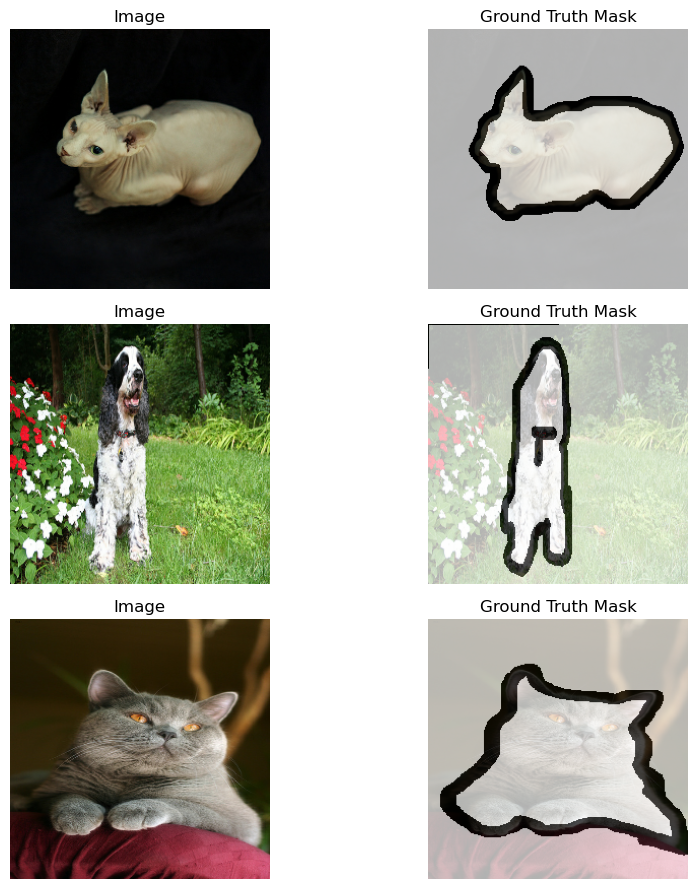

In [23]:
images, masks = next(iter(train))
plot_predictions_grid(images, masks, num_samples=3)

## Building U-Net: Encoder Block [30/30]

Next, we will use the `double_conv_block()` method as a fundamental building block to implement the U-Net architecture. As illustrated in Figure 1 of the original paper, [U-Net](https://arxiv.org/pdf/1505.04597) has three main components: **encoder** (downsampling path), **bottleneck**, and **decoder** (upsampling path).

We will use `keras.layers.Conv2D` to build the **core building block** of U-Net `double_conv_block()`. Each block applies **two** consecutive convolution layers to extract richer spatial features while keeping the **same* height and width.

When using `keras.layers.Conv2D`, we need to specify:

- `filters` – number of output feature maps (e.g., 32, 64, 128, …).  
- `kernel_size` – size of the convolution window (e.g., `3` means 3×3).  
- `strides` – how far the filter moves each step; default is `1`.  
- `padding` – `"same"` keeps the spatial size unchanged, `"valid"` mean no padding.  
- `activation` – nonlinear function applied after convolution (we use `"relu"`).

In U-Net, we use **two consecutive 3×3 convolutions** (each with ReLU activation and `"same"` padding) so that:
- The network can learn complex local features.
- The output feature map has the **same** height and width as the input (important for skip connections).

In [24]:
def double_conv_block(x, num_f):
    x = layers.Conv2D(num_f, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(num_f, kernel_size=3, padding='same', activation='relu')(x)
    return x

The **encoder block** forms the *downsampling path* of U-Net. It first extracts meaningful local features with `double_conv_block()` and then applies **max pooling** to reduce spatial resolution, allowing the network to capture increasingly abstract patterns.

We will use `keras.layers.MaxPooling2D`, which performs a *non-learnable downsampling* by taking the **maximum value** within each local patch. This helps retain strong local features (edges, textures) while discarding minor noise or variations.

When using `keras.layers.MaxPooling2D`, we need to specify:

- **`pool_size`** – the size of the pooling window (e.g., `2` downscale by 2× in height and width).  
- **`strides`** – how far the window moves each step (default = `pool_size`).  
- **`padding`** – determines how to handle image borders (usually `"valid"` for pooling).

> **Note**: Applying `layers.MaxPooling2D(pool_size=2)` **halves** the spatial dimensions. Return both: `x`: features *before pooling* (used later as a **skip** connection); and `p`: pooled features (input for the next encoder stage).



In [25]:
def encoder_block(x, num_f):
    x = double_conv_block(x, num_f) # feature extraction (same H,W)
    p = layers.MaxPooling2D(pool_size=2, padding='valid')(x) # downsample by 2, with default stride 
    return x, p

## Building U-Net: Decoder Block [20/20]

Next, we will build the `decoder_block()` for the **decoder (upsampling) stage** to reconstructs spatial detail. At each block, we:
1. **Upsample** the feature map with a transposed convolution (`keras.layers.Conv2DTranspose`) to double its height/width.  
2. **Concatenate** the upsampled features with the corresponding **skip** features from the encoder (same scale) using `keras.layers.Concatenate()`.  
3. **Refine** the fused features using our `double_conv_block()` (two 3×3 convs with `"same"` padding).

**Layers used:**
- **`keras.layers.Conv2DTranspose(filters, kernel_size, strides, padding)`**  
  - `filters`: number of output channels after upsampling (`num_f` for this stage).  
  - `kernel_size`: usually `2` for a clean ×2 upsample.  
  - `strides`: typically `2`; inserts `strides-1` rows/cols of zeros between pixels to **expand** the feature map.  
  - `padding`: `"same"` to keep sizes aligned with the encoder’s skip tensor.

- **`keras.layers.Concatenate()`**  
  - Merges `[upsampled_x, skip]` **along the channel axis**, assuming **same height/width**.  
  - Because we used `"same"` padding in encoder/decoder, sizes already match (no cropping needed).

Our implementation is the classic U-Net decoder block following the **deconv-> concat-convs** pattern.




In [26]:
# deconv -> concat -> convs  (classic U-Net)
def decoder_block(x, skip, num_f):
    x = layers.Conv2DTranspose(num_f, kernel_size=2, strides=2, padding='same')(x) # upsample (H,W) x2
    x = layers.Concatenate()([x, skip]) # fuse with encoder skip
    x = double_conv_block(x, num_f) # refine features
    return x

## Building U-Net: Integrating Encoder/Decoder Blocks [30/30]

We now assemble encoder blocks, a bottleneck, decoder blocks, and a 1×1 head.

- *Encoder (4 stages)*: each stage applies `encoder_block(x, num_f)` for feature extraction and **halves** spatial size using pooling; filters **double** at each stage (`base_num_f, 2×, 4×, 8×`).
- *Bottleneck*: a single `double_conv_block` at the deepest resolution with the **largest** number of filters (`16× base_num_f`).
- *Decoder (4 stages)*: each stage uses `decoder_block(x, skip, num_f)` to **double** the spatial resolution, concatenate with the corresponding encoder *skip connection*, and refine the features; filters **halve** progressively (`8×, 4×, 2×, 1×`).
- *Head*: a `Conv2D(1×1)` layer with activation — *sigmoid* for binary segmentation or *softmax* for multi-class.

- The input height and width should match the global setting: `IMG_SIZE × IMG_SIZE`.



In [27]:
def make_unet(input_shape=(256, 256, 3), base_num_f=32, num_classes=1, final_act=None):
    """
    Tiny U-Net. Input H,W should be divisible by 16 (four downsamples).
    final_act: None -> auto ('sigmoid' if num_classes==1 else 'softmax').
    """
    h, w, _ = input_shape
    assert h % 16 == 0 and w % 16 == 0, "Input H,W must be multiples of 16."

    inputs = keras.Input(shape=input_shape)

    # Encoder
    f1, p1 = encoder_block(inputs, base_num_f) # 256 -> 128
    f2, p2 = encoder_block(p1, base_num_f * 2)  # 128 -> 64
    f3, p3 = encoder_block(p2, base_num_f * 4) # 64  -> 32
    f4, p4 = encoder_block(p3, base_num_f * 8) # 32  -> 16

    # Bottleneck
    bn = double_conv_block(p4, base_num_f * 16)

    # Decoder
    d4 = decoder_block(bn, f4, base_num_f * 8) # 16 -> 32
    d3 = decoder_block(d4, f3, base_num_f * 4)  # 32 -> 64
    d2 = decoder_block(d3, f2, base_num_f * 2) # 64 -> 128
    d1 = decoder_block(d2, f1, base_num_f) # 128 -> 256

    # Head
    act = final_act if final_act is not None else ('sigmoid' if num_classes == 1 else 'softmax')
    outputs = layers.Conv2D(num_classes, 1, activation=act, padding='same')(d1)

    return keras.Model(inputs, outputs, name='U-Net')

In [28]:
model = make_unet(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=1, final_act='sigmoid')

## Visualizing the Model Architecture

Keras provides a convenient `plot_model()` utility to visualize the network structure as a diagram. Below, we save and display the model architecture.  
You can adjust parameters such as:
- `dpi`: resolution of the output image  
- `show_shapes=True`: display tensor shapes beside each layer  
- `rankdir`: layout direction ('TB' for top-to-bottom, 'BT' for bottom-to-top, 'LR' for left-to-right, 'RL' for right-to-left)

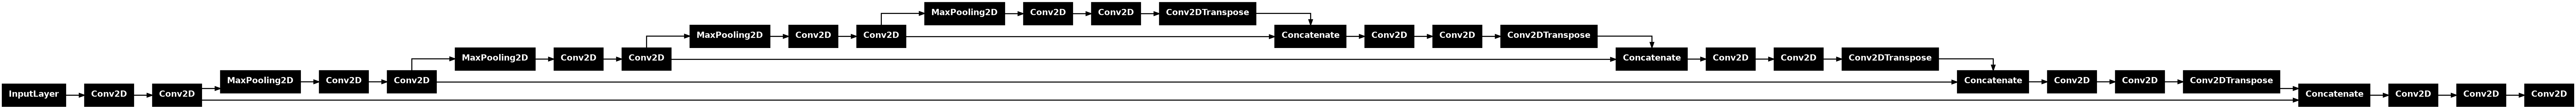

In [29]:
plot_model(
    model,
    to_file="unet.png",
    show_shapes=False,
    show_layer_names=False,
    dpi=120,
    rankdir='LR',   # horizontal layout
    expand_nested=False
)

## Compile, Train, and Visualize Loss [10/10]

We now compile and train the U-Net model for binary segmentation.

- *Optimizer*: Adam, using the global learning rate `LEARNING_RATE`.  
- *Loss*: Binary cross-entropy, suitable for sigmoid outputs.  
- *Validation*: use the test set for validation loss tracking.  
- *Epochs*: controlled by the global variable `EPOCHS`.

After training, we plot the training and validation loss curves to observe convergence and potential overfitting.


In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy()
)

In [31]:
# Train the model
history = model.fit(
    train,
    validation_data=test,
    epochs=EPOCHS
)


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.3922 - val_loss: 0.3207
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.2856 - val_loss: 0.2772
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.2578 - val_loss: 0.2541
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.2397 - val_loss: 0.2393
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.2280 - val_loss: 0.2349
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.2185 - val_loss: 0.2181
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.2102 - val_loss: 0.2120
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.2021 - val_loss: 0.2084
Epoch 9/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.1966 - val_loss: 0.2142
Epoch 10/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.1923 - val_loss: 0.2077


In [32]:
def plot_history(hist, log_scale=False):
  plt.figure(figsize=(8,5))
  plt.plot(hist.history["loss"], color="blue", linestyle="-", label="train")
  plt.plot(hist.history["val_loss"], color="red", linestyle="--", label="val")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.grid(True, which="both", ls=":")
  if log_scale:
      plt.yscale("log")
      plt.ylabel("Loss (log scale)")
  plt.show()

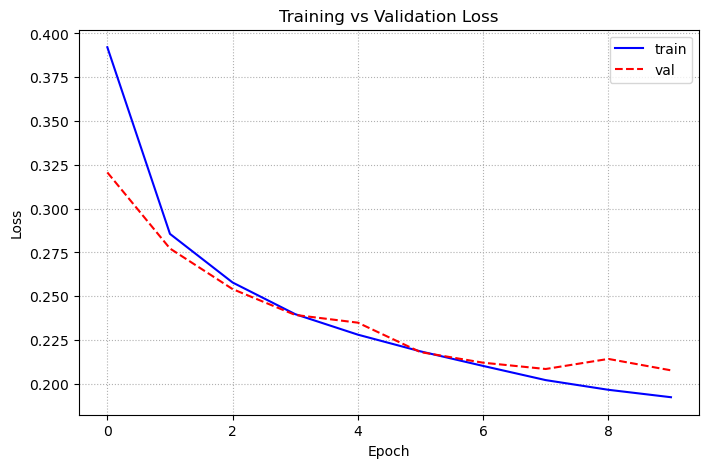

In [33]:
plot_history(history)

## Visualizing Model Predictions

Finally, we can visualize the model’s segmentation results on both training and testing samples.
- Take a small batch from the dataset.  
- Run `model.predict()` to obtain predicted masks.  
- Apply a threshold of 0.5 to convert the output probabilities into binary masks.  
- Use `plot_predictions_grid()` to visualize input images, ground truth masks, and predicted masks side by side.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


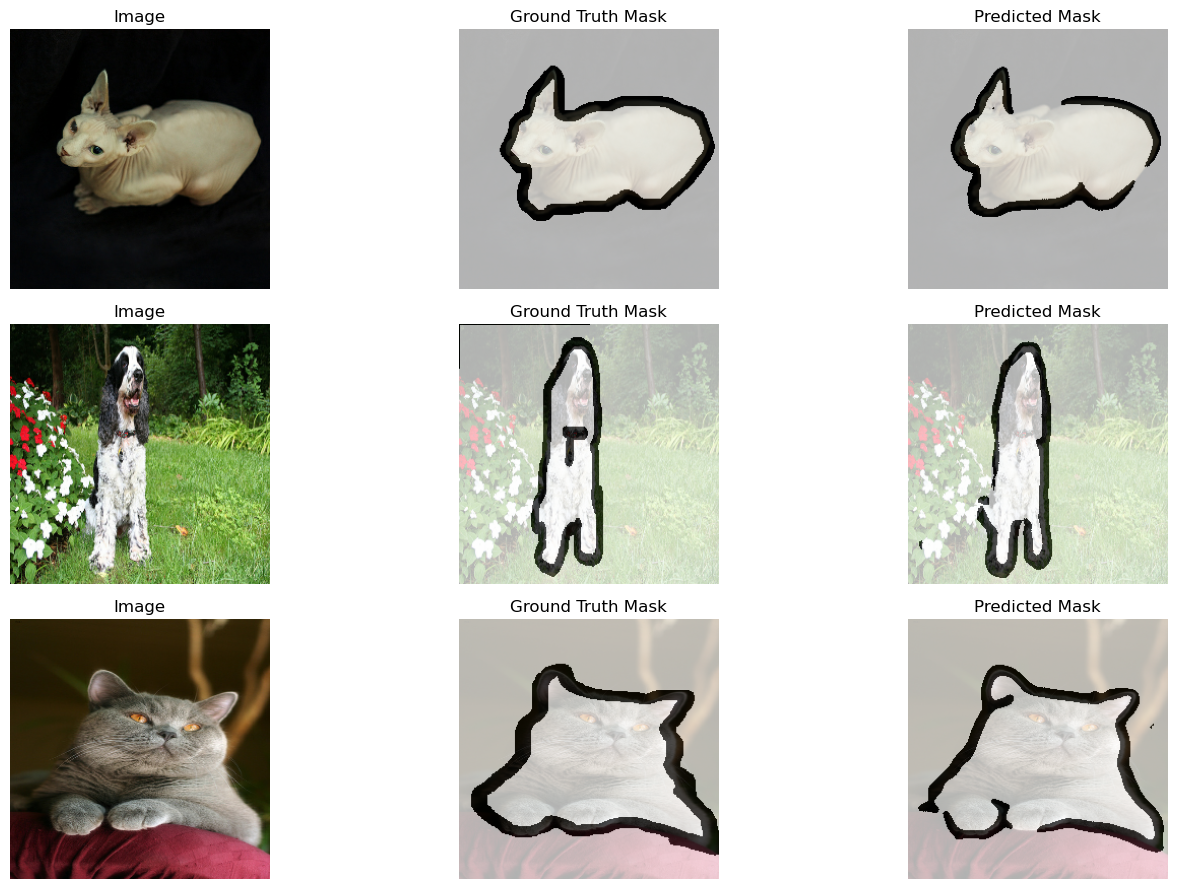

In [34]:
images, masks = next(iter(train))
preds = model.predict(images)
preds = (preds > 0.5).astype("float32")  # threshold for binary mask

plot_predictions_grid(images, masks, preds, num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


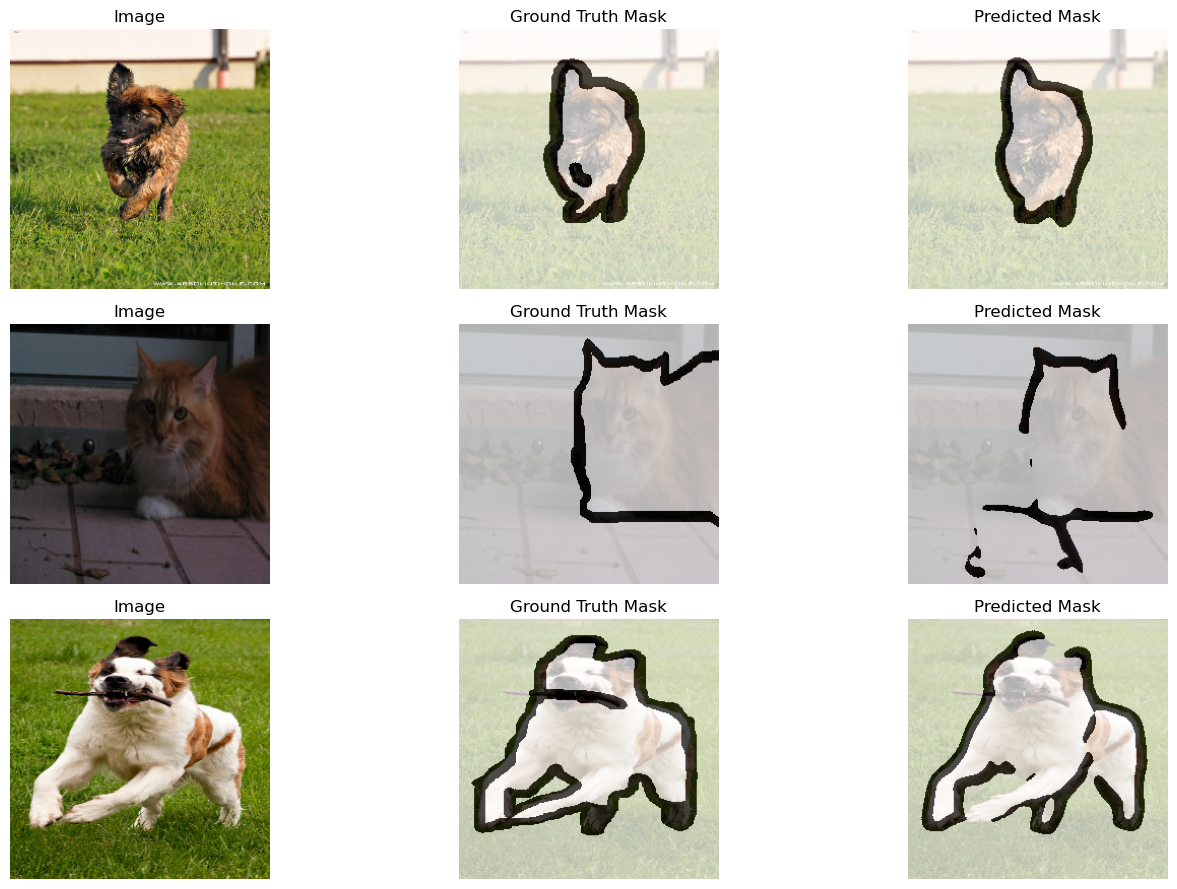

In [35]:
images, masks = next(iter(test))
preds = model.predict(images)
preds = (preds > 0.5).astype("float32")  # threshold for binary mask

plot_predictions_grid(images, masks, preds, num_samples=3)